In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from torchvision import datasets, models, transforms

# Base Directory where data is stored
PATH = '/media/rene/Data/camelyon_out/tiles_299_100t/'

fast_ai_dir = '/media/rene/Data/fastai/'
sys.path.append(fast_ai_dir)

# Set it to use GPU1
torch.cuda.set_device(1)
print(torch.cuda.is_available())
print(torch.cuda.current_device())

True
1


In [7]:
class AllModels(nn.Module):
    """Fast ai models will all have 2 outputs, so the final will have 2*9. 
       We just use linear layer, loss handles softmax"""
    def __init__(self, num_classes):
        super(AllModels, self).__init__()
        
        models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, dn121, dn169]
        models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'dn121', 'dn169']
        sz = 224
        PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'
        self.models = {}
        
        for idx, arch in enumerate(models_arch):
            tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
            data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=2)
            learn = ConvLearner.pretrained(arch, data, precompute=False)
            self.models[idx] = learn.model
        self.fc = nn.Linear(9*int(num_classes), int(num_classes))

    def forward(self, x):
        self.int_output = {}
        for key, model in self.models.items():
            self.int_output[key] = model(x)

        x = torch.cat(list(self.int_output.values()), 1)
        print(x.size())
        x = self.fc(x)
        return x

In [5]:
sz=224
PATH = '/media/rene/Data/camelyon_out/tiles_224_1t'
arch = resnet50

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=64)
# use transforms for resnet 50 for all models
model = AllModels()
learn = ConvLearner.from_model_data(model, data)

learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]

 93%|█████████▎| 14/15 [00:19<00:01,  1.40s/it, loss=4.81] 

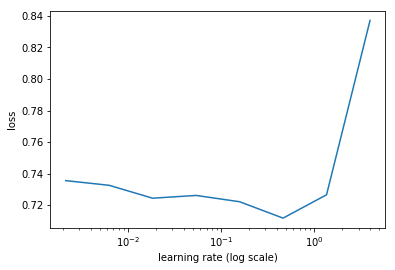

In [7]:
lrf=learn.lr_find(start_lr=1e-5, end_lr=100)
learn.sched.plot(n_skip=5, n_skip_end=1)

In [8]:
lr = .5
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2, best_save_name='All_9_models_no_unfreeze_1t')

  0%|          | 0/15 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   accuracy                  
    0      0.733681   0.853295   0.5       
    1      1.116728   1.435955   0.532967                 
    2      1.063733   0.960586   0.571429                 
    3      1.194744   2.185524   0.538462                 
    4      1.158813   1.617156   0.510989                 
    5      1.142954   1.161306   0.505495                 
 20%|██        | 3/15 [00:04<00:18,  1.52s/it, loss=1.12]

KeyboardInterrupt: 

In [9]:
lr = .05
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2, best_save_name='All_9_models_no_unfreeze_1t')

  0%|          | 0/15 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   accuracy                  
    0      0.743899   0.81937    0.56044   
    1      0.691748   0.759568   0.538462                  
    2      0.679591   0.756859   0.538462                  
    3      0.665791   0.863565   0.543956                  
    4      0.674902   0.757745   0.571429                  
    5      0.667055   0.707331   0.565934                  
    6      0.651383   0.727375   0.527473                  

CPU times: user 3min 51s, sys: 1min 16s, total: 5min 8s
Wall time: 2min 45s


[array([0.72737]), 0.5274725274725275]

  0%|          | 0/15 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   accuracy                  
    0      0.653028   0.752621   0.489011  
    1      0.636556   0.706875   0.571429                  
    2      0.639674   0.713004   0.571429                  
    3      0.630856   0.710105   0.576923                  
    4      0.639934   0.711303   0.587912                  
    5      0.637194   0.724019   0.565934                  
    6      0.635423   0.714293   0.549451                  
    7      0.632548   0.702087   0.56044                   
    8      0.634262   0.72953    0.565934                  
    9      0.626967   0.735903   0.527473                  

CPU times: user 5min 41s, sys: 1min 37s, total: 7min 18s
Wall time: 3min 56s


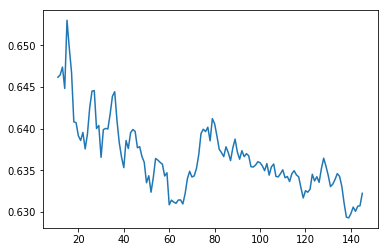

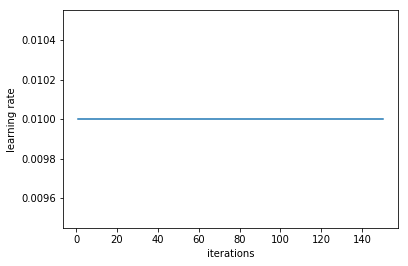

In [16]:
lr = .01
%time learn.fit(lr, 10, best_save_name='All_9_models_no_unfreeze_1t')
plt.figure()
learn.sched.plot_loss()
plt.figure()
learn.sched.plot_lr()

epoch      trn_loss   val_loss   accuracy                  
    0      0.616013   0.738765   0.554945  
    1      0.620908   0.712044   0.554945                  
    2      0.632399   0.695477   0.56044                   
    3      0.624471   0.735457   0.543956                  
    4      0.627097   0.665202   0.587912                  
    5      0.626983   0.692658   0.582418                  
    6      0.627358   0.74861    0.532967                  
    7      0.628745   0.738105   0.56044                   
    8      0.627393   0.724556   0.532967                  
    9      0.62692    0.74476    0.516484                  

CPU times: user 5min 43s, sys: 1min 37s, total: 7min 20s
Wall time: 3min 56s


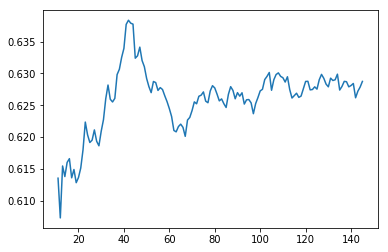

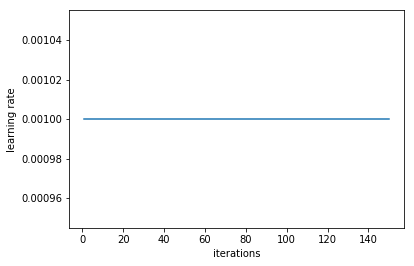

In [17]:
lr = .001
%time learn.fit(lr, 10, best_save_name='All_9_models_no_unfreeze_1t')
plt.figure()
learn.sched.plot_loss()
plt.figure()
learn.sched.plot_lr()

In [3]:
sz=299 # so the inception models work
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'
arch = resnet50

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=32)
# use transforms for resnet 50 for all models
model = AllModels()
learn = ConvLearner.from_model_data(model, data)

In [ ]:
lr = .001
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]

%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2, best_save_name='All_9_models_no_unfreeze_training')

epoch      trn_loss   val_loss   accuracy                      
    0      0.587214   0.7768     0.507246  
 69%|██████▉   | 1796/2604 [40:13<18:05,  1.34s/it, loss=0.602]

### check that models are actually training. Both that outputs are coming from all models, and that we are actually using the gradient for all models. Need to set some train thing?

In [ ]:
sz=299 # so the inception models work
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'
arch = resnet50

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=4)
# use transforms for resnet 50 for all models
model = AllModels()
learn = ConvLearner.from_model_data(model, data)

In [ ]:
lr = .001
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
learn.unfreeze()
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2, best_save_name='All_9_models_Actually_fully_training')

## Try on CIFAR10 to see whats going on

In [4]:
# CUDA_LAUNCH_BLOCKING=1
torch.cuda.synchronize()

PATH = "/media/rene/Data/data/cifar10/sample"
num_workers = 4
bs=2
sz=224
# stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))
# tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)

arch = resnet50
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)

data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

model = AllModels(num_classes=10)
learn = ConvLearner.from_model_data(model, data)

In [3]:
lr = 1
wd=1e-4
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(20, 20, 0.95, 0.85))

NameError: name 'learn' is not defined

## Another Way

In [2]:
def train_model(model, model_list, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
        
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in tqdm(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
                    
                ######### Get model outputs
                features = []
                for model in model_list:
                    output = model(inputs)
                    features.append(output)
                cat_features = torch.cat(features, 1)
                    
                ###########
                    
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = fc_net(cat_features)

                # for nets that have multiple outputs such as inception
                if isinstance(outputs, tuple):
                    loss = sum((criterion(o,labels) for o in outputs))
                else:
                    loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    _, preds = torch.max(outputs.data, 1)
                    loss.backward()
                    optimizer.step()
                else:
                    _, preds = torch.max(outputs.data, 1)

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [3]:
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(9*2, 10)
        self.fc2_bn = nn.BatchNorm2d(10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        out1 = F.relu(self.fc2_bn(self.fc1(x)))
        out2 = self.fc2(out1)
        return out2
    
    
fc_net = FCNet()
model = fc_net.cuda()

In [5]:
from torch.optim import lr_scheduler

batch_size = 64
num_workers = 4
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x])/10 for x in ['train', 'valid']}
class_names = image_datasets['valid'].classes

In [6]:
sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'

# models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, dn121, dn169]
# for arch in models_arch:
#     tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
#     data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=2)
#     learn = ConvLearner.pretrained(arch, data, precompute=False)
#     model_list.append(learn.model)

# loc = '/media/rene/Data/camelyon_out/tiles_224_100t/models'
models_name = ['resnet34_full_0', 'resnet50_full_0', 'resnet101_full_0', 
               'vgg16_full', 'resnext50_full', 'resnext101_full', 'inceptionresnet_2_full',
               'dn121_full', 'dn169_full_0']

models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, dn121, dn169]
# models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']


model_list = []
for idx, arch in enumerate(models_arch):
    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=4)
    
    model_loc = os.path.join(PATH, 'models', models_name[idx])
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    learn.load(model_loc)
    model_list.append(learn.model)

num_epochs = 20
save_path = '/media/rene/Data/camelyon/output/tmp/ensemble_model3'
    

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

model = train_model(model, model_list, 
                    criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)
torch.save(model.state_dict(), save_path)

# with open('/media/rene/Data/camelyon_out/tiles_224_100t/tmp/output.txt', 'w') as out:
#     out.write(cap.stdout)

  0%|          | 0/20 [00:00<?, ?it/s]Epoch 0/19
----------
100%|██████████| 1302/1302 [28:16<00:00,  1.30s/it]
train Loss: 1.5898 Acc: 9.4327
100%|██████████| 261/261 [05:37<00:00,  1.29s/it]
valid Loss: 1.3513 Acc: 9.4707
  5%|▌         | 1/20 [33:53<10:44:00, 2033.71s/it]Epoch 1/19
----------
100%|██████████| 1302/1302 [28:19<00:00,  1.30s/it]
train Loss: 0.8609 Acc: 9.6832
100%|██████████| 261/261 [05:38<00:00,  1.30s/it]
valid Loss: 1.3757 Acc: 9.4683
 10%|█         | 2/20 [1:07:50<10:10:38, 2035.46s/it]Epoch 2/19
----------
100%|██████████| 1302/1302 [28:19<00:00,  1.31s/it]
train Loss: 0.8575 Acc: 9.6834
100%|██████████| 261/261 [05:38<00:00,  1.30s/it]
valid Loss: 1.3699 Acc: 9.4677
 15%|█▌        | 3/20 [1:41:48<9:36:54, 2036.16s/it] Epoch 3/19
----------
 33%|███▎      | 428/1302 [09:19<19:01,  1.31s/it]

Process Process-28:
Process Process-27:
Process Process-26:
Process Process-25:
Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/da

KeyboardInterrupt: 

In [4]:
from torch.optim import lr_scheduler

batch_size = 64
num_workers = 4
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
              for x in ['train', 'valid']}

dataset_sizes = {}
dataset_sizes['train'] = len(image_datasets['train'])/10
dataset_sizes['valid'] = len(image_datasets['valid'])/10

class_names = image_datasets['valid'].classes

In [5]:
sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'

# models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, dn121, dn169]
# for arch in models_arch:
#     tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
#     data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=2)
#     learn = ConvLearner.pretrained(arch, data, precompute=False)
#     model_list.append(learn.model)

# loc = '/media/rene/Data/camelyon_out/tiles_224_100t/models'
models_name = ['resnet34_full_0', 'resnet50_full_0', 'resnet101_full_0', 
               'vgg16_full', 'resnext50_full', 'resnext101_full', 'inceptionresnet_2_full',
               'dn121_full', 'dn169_full_0']

models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, dn121, dn169]
# models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']


model_list = []
for idx, arch in enumerate(models_arch):
    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=4)
    
    model_loc = os.path.join(PATH, 'models', models_name[idx])
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    learn.load(model_loc)
    model_list.append(learn.model)

num_epochs = 2
save_path = '/media/rene/Data/camelyon/output/tmp/ensemble_model2'
    

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

model = train_model(model, model_list, 
                    criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)
torch.save(model.state_dict(), save_path)

# with open('/media/rene/Data/camelyon_out/tiles_224_100t/tmp/output.txt', 'w') as out:
#     out.write(cap.stdout)

  0%|          | 0/2 [00:00<?, ?it/s]Epoch 0/1
----------
100%|██████████| 1302/1302 [29:10<00:00,  1.34s/it]
train Loss: 1.4463 Acc: 9.5568
100%|██████████| 261/261 [05:48<00:00,  1.34s/it]
valid Loss: 1.3515 Acc: 9.4826
 50%|█████     | 1/2 [34:59<34:59, 2099.57s/it]Epoch 1/1
----------
100%|██████████| 1302/1302 [29:12<00:00,  1.35s/it]
train Loss: 0.8667 Acc: 9.6783
100%|██████████| 261/261 [05:49<00:00,  1.34s/it]
valid Loss: 1.3530 Acc: 9.4850
100%|██████████| 2/2 [1:10:01<00:00, 2100.50s/it]Training complete in 70m 1s
Best valid Acc: 9.485030


In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(args.data_loc, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=args.batch_size,
                                             shuffle=True, num_workers=args.num_workers)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes




ensemble_dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=args.batch_size,
                                             shuffle=True, num_workers=args.num_workers)
              for x in ['train', 'valid']}




class EnsembleDataloader(Dataset):
    """Ensemble dataset."""
    def __init__(self, PATH, models, transform=None):
        self.PATH = PATH
        self.models = models
        self.transform = transform
        self.all_data = glob.glob(PATH+'/**/*.png', recursive=True)

    def __len__(self):
        return len(self.all_data)

    def __getitem__(self, idx):
        image_datasets = {x: datasets.ImageFolder(os.path.join(args.data_loc, x),
                                                  data_transforms[x])
                          for x in ['train', 'valid']}

        dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=args.batch_size,
                                                     shuffle=True, num_workers=args.num_workers)
                      for x in ['train', 'valid']}

        
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample


num_workers = 4
bs = 2
    
ensemble_datasets = {x: EnsembleDataloader(os.path.join(args.data_loc, x))
                  for x in ['train', 'valid']}

ensemble_dataloader = {x: torch.utils.data.DataLoader(ensemble_datasets[x], batch_size=bs,
                                             shuffle=False, num_workers=num_workers)
              for x in ['train', 'valid']}

In [ ]:

model_ft = models.resnet50(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                   num_epochs=args.epochs)
torch.save(model_ft.state_dict(), args.save_path)